### 问题与总结
1. 为什么from_logits必须设置False？    
2. 注意：再更新G的时候用的是全1标签


In [1]:
import mxnet as mx
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn
import numpy as np
from datetime import datetime
import os
import time

### 第一部分：最简单的例子——Generate a Gaussian Estimator

In [2]:
ctx = mx.gpu(0)

* 首先：产生一些“真实”数据

In [3]:
X = nd.random_normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
X = nd.dot(X, A) + b
Y = nd.ones(shape=(1000, 1))

In [4]:
# and stick them into an iterator
batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

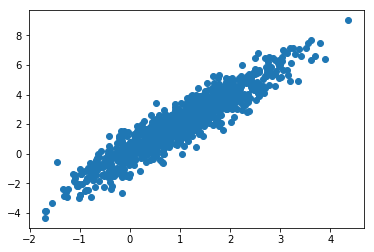

The covariance matrix is

[[1.01 1.95]
 [1.95 4.25]]
<NDArray 2x2 @cpu(0)>


In [5]:
plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy())
plt.show()
print("The covariance matrix is")
print(nd.dot(A.T, A))

* 定义一个简单的网络

In [6]:
# generator
netG = nn.Sequential()
with netG.name_scope():
    netG.add(nn.Dense(2))
    
# descriminator
netD = nn.Sequential()
with netD.name_scope():
    netD.add(nn.Dense(5, activation='sigmoid'))
    netD.add(nn.Dense(3, activation='sigmoid'))
    netD.add(nn.Dense(2))

# loss
loss = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=False)

# 初始化两个网络
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# 定义trainer
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.05})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.05})

In [7]:
real_label = mx.nd.ones((batch_size,), ctx=ctx)
fake_label = mx.nd.zeros((batch_size,), ctx=ctx)
metric = mx.metric.Loss()

<IPython.core.display.Javascript object>


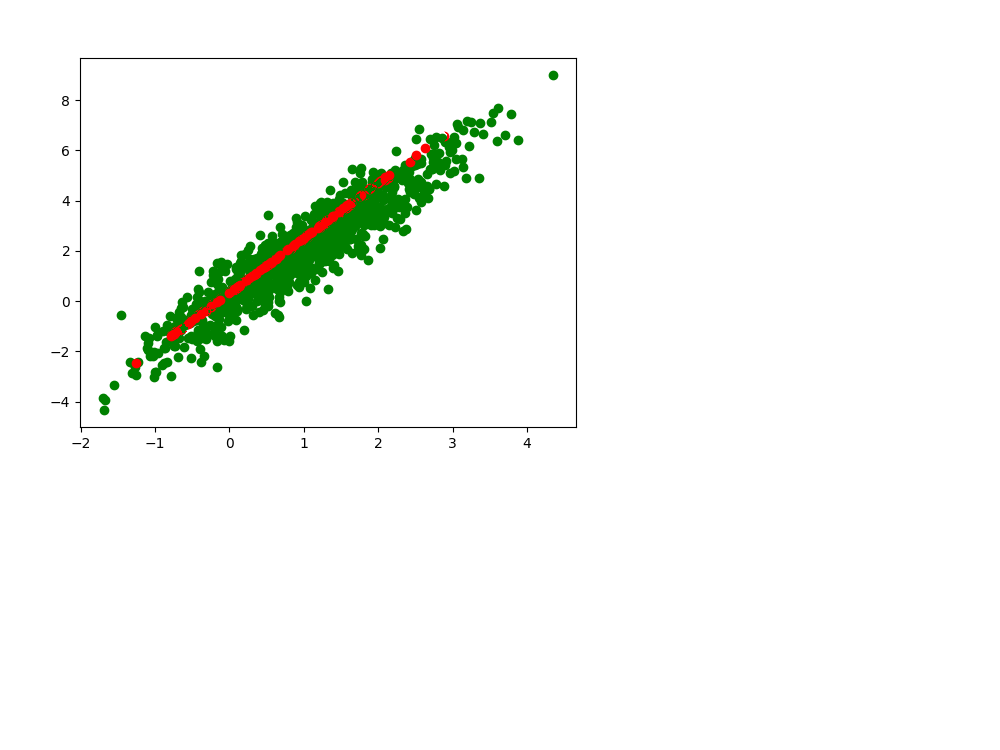


binary training acc at epoch 0: loss=0.000516
time: 1.095866

binary training acc at epoch 1: loss=-0.000091
time: 1.154933

binary training acc at epoch 2: loss=0.000003
time: 1.153084

binary training acc at epoch 3: loss=0.000004
time: 1.129155

binary training acc at epoch 4: loss=0.000007
time: 1.228370

binary training acc at epoch 5: loss=0.000010
time: 1.153372

binary training acc at epoch 6: loss=0.000012
time: 1.171706

binary training acc at epoch 7: loss=0.000016
time: 1.115526

binary training acc at epoch 8: loss=0.000020
time: 1.197983

binary training acc at epoch 9: loss=0.000025
time: 1.253530

binary training acc at epoch 10: loss=0.000030
time: 1.144564

binary training acc at epoch 11: loss=0.000037
time: 1.127142

binary training acc at epoch 12: loss=0.000045
time: 1.183016

binary training acc at epoch 13: loss=0.000053
time: 1.099959

binary training acc at epoch 14: loss=0.000063
time: 1.162426

binary training acc at epoch 15: loss=0.000073
time: 1.145455



In [ ]:
%matplotlib notebook
fig = plt.figure()
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
for epoch in range(1000):
    plt.clf()
    tic = time.time()
    train_data.reset()
    metric.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        noise = nd.random.normal(shape=(batch_size, 2)).as_in_context(ctx)
        #### Update D: maximize log(D(x)) + log(1 - D(G(z)))
        with autograd.record():
            fake = netG(noise)
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()
        trainerG.step(batch_size)
        
        with autograd.record():
            real_output = netD(data)
            errD_real = loss(real_output, real_label)
            fake = netG(noise)
            fake_output = netD(fake.detach())
            errD_fake = loss(fake_output, fake_label)
            errD = errD_fake + errD_real
            errD.backward()
        trainerD.step(batch_size)
        metric.update([real_label, ], [real_output,])
        metric.update([fake_label, ], [fake_output, ])  #??? metric函数待进一步了解
        
        #### Update G network: maximize log(D(G(z)))
        ## 注意：这里不再用real图像进行前向传播，因为netG只对fake和其参数求梯度，不对real求梯度。即real图像不参与netG的反向传播。故不需要计算
        
    name, acc = metric.get()
    
    print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    print('time: %f' % (time.time() - tic))
    #### 测试当前epoch在测试集的输出
    noise = nd.random_normal(shape=(100, 2), ctx=ctx)
    fake = netG(noise)
    plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy(),c='g')
    plt.scatter(fake[:,0].asnumpy(), fake[:,1].asnumpy(), c='r')
    plt.show()
    fig.canvas.draw()

#### Training Loop

① NDArray.detach()函数： 如果计算图构建完成，之后不需要用到计算图中某个节点的时候 可以detach() 这时候这些节点会从计算图中被去掉，从而缓解显存的占用量  
② 注意：每个网络的参数更新与否是由其Trainer实现确定的

<IPython.core.display.Javascript object>


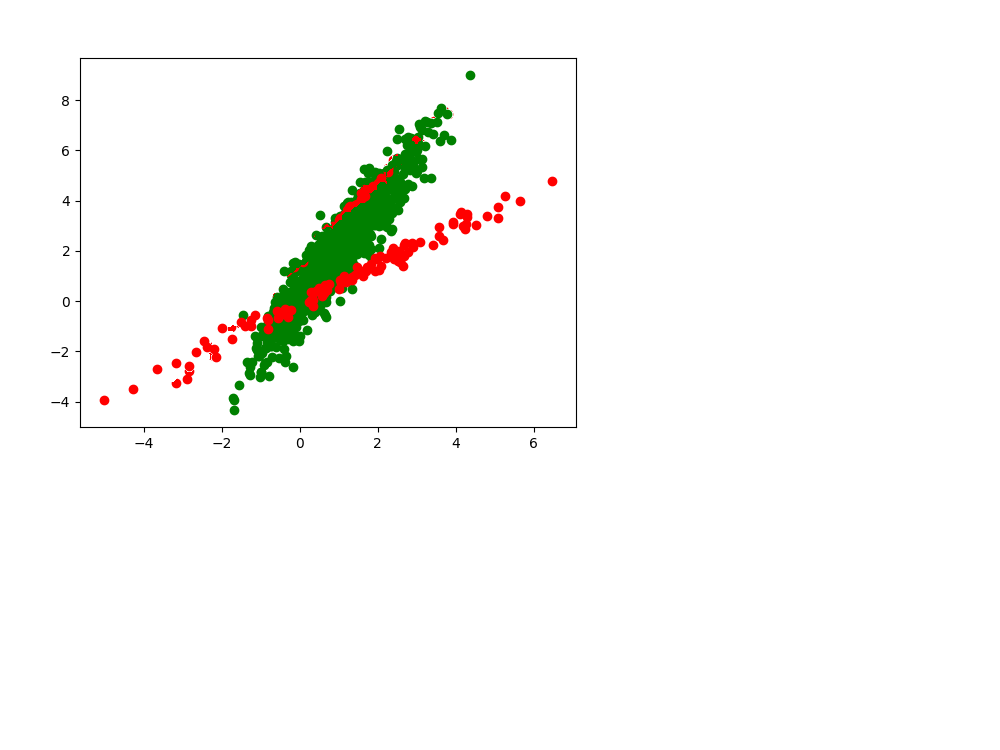


binary training acc at epoch 0: loss=0.026123
time: 1.118626

binary training acc at epoch 1: loss=0.024195
time: 1.188582

binary training acc at epoch 2: loss=0.026041
time: 1.208538

binary training acc at epoch 3: loss=0.024722
time: 1.120907

binary training acc at epoch 4: loss=0.025384
time: 1.104895

binary training acc at epoch 5: loss=0.026740
time: 1.187353

binary training acc at epoch 6: loss=0.027007
time: 1.089154

binary training acc at epoch 7: loss=0.027047
time: 1.169271

binary training acc at epoch 8: loss=0.027061
time: 1.185563

binary training acc at epoch 9: loss=0.027069
time: 1.168936

binary training acc at epoch 10: loss=0.027114
time: 1.075334

binary training acc at epoch 11: loss=0.027151
time: 1.212815

binary training acc at epoch 12: loss=0.027124
time: 1.182479

binary training acc at epoch 13: loss=0.027014
time: 1.192014


In [ ]:
%matplotlib notebook
fig = plt.figure()
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
for epoch in range(1000):
    plt.clf()
    tic = time.time()
    train_data.reset()
    metric.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        noise = nd.random.normal(shape=(batch_size, 2)).as_in_context(ctx)
        #### Update D: maximize log(D(x)) + log(1 - D(G(z)))
        with autograd.record():
            real_output = netD(data)
            errD_real = loss(real_output, real_label)
            fake = netG(noise)
            fake_output = netD(fake.detach())
            errD_fake = loss(fake_output, fake_label)
            errD = errD_fake + errD_real
            errD.backward()
        
        trainerD.step(batch_size)
        metric.update([real_label, ], [real_output,])
        metric.update([fake_label, ], [fake_output, ])  #??? metric函数待进一步了解
        
        #### Update G network: maximize log(D(G(z)))
        ## 注意：这里不再用real图像进行前向传播，因为netG只对fake和其参数求梯度，不对real求梯度。即real图像不参与netG的反向传播。故不需要计算
        with autograd.record():
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()
        trainerG.step(batch_size)
    name, acc = metric.get()
    
    print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    print('time: %f' % (time.time() - tic))
    #### 测试当前epoch在测试集的输出
    noise = nd.random_normal(shape=(100, 2), ctx=ctx)
    fake = netG(noise)
    plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy(),c='g')
    plt.scatter(fake[:,0].asnumpy(), fake[:,1].asnumpy(), c='r')
    plt.show()
    fig.canvas.draw()

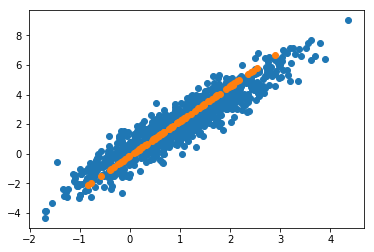

In [25]:
%matplotlib inline
noise = mx.nd.random_normal(shape=(100, 2), ctx=ctx)
fake = netG(noise)

plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy())
plt.scatter(fake[:,0].asnumpy(), fake[:,1].asnumpy())
plt.show()

In [19]:
tt = nd.random.normal(shape=(3,5))

In [19]:
test_batch = train_data.next()
data = test_batch.data[0].as_in_context(ctx)

In [24]:
real_output = netD(data)

In [21]:
noise = nd.random.normal(shape=(4,2),ctx=ctx)
fake = netG(noise)

In [25]:
fake_output = netD(fake)

In [30]:
loss(real_output, real_label)


[-4.1083535e-05  1.0566706e-04 -2.4969577e-05  3.0727089e-05]
<NDArray 4 @gpu(0)>

SoftmaxCrossEntropyLoss(batch_axis=0, w=None)